In [114]:
import sys
import util
from Polygenic_score import *

import os
import subprocess
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics
import re

In [115]:
def clump_sorted_snps(bfile, assoc_file, snp_values, sorted_snps):

    clump_out = assoc_file[:assoc_file.index(".assoc")] + "_clump"
    cmd_plink_clump = "plink --bfile {} --clump {} --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out {} ".format(bfile,
            assoc_file,
            clump_out)
    print cmd_plink_clump
    p = subprocess.Popen(cmd_plink_clump, shell=True)
    p.wait()

    clumped_res = pd.read_table(clump_out+".clumped", delim_whitespace=True)
    clumped_snps = set(clumped_res.SNP)

    clumped_sorted_snps = np.array([i for i in sorted_snps if snp_values[i] in clumped_snps])
    return clumped_sorted_snps



In [116]:
def save_strat(strat_file, strat):
    pca_res = pd.read_table(strat_file, delim_whitespace=True, skiprows=1, header=None)
    PCs_out = strat + ".PCs"
    with open(PCs_out, "a") as f:
        f.write(', '.join(pca_res[0].values))
        f.write('\n')
        f.write(str(pca_res[2].values.tolist())[1:-1])
        f.write('\n')
        f.write(str(pca_res[3].values.tolist())[1:-1])
        f.write('\n')


In [117]:
def plink_prune(plink_bfile):

    cmd_prune = """plink --bfile {}      --exclude /home/vcabeli/Documents/data/high-LD-regions_37.txt           --range --indep-pairwise 50 5 0.2           --allow-extra-chr           --out {}""".format(plink_bfile, plink_bfile+"_prune")
    p = subprocess.Popen(cmd_prune, shell=True)
    assert(p.wait() == 0)

    cmd_extract = """plink --bfile {}           --extract {}           --allow-extra-chr           --chr 1-23           --make-bed           --out {}""".format(plink_bfile, plink_bfile + "_prune.prune.in", 
                             plink_bfile + "_pruned")
    p = subprocess.Popen(cmd_extract, shell=True)
    assert(p.wait() == 0)

    print "Wrote {} bed/bim/fam.".format(plink_bfile + "_pruned")



In [118]:
def write_cov_file(pca_file,nb_pc):

    cmd_sed = "sed -i -e \"s/:/ /g\" -e \"s/\s\+/\t/g\" -e \"s/^\s\+//g\" {}".format(pca_file)
    p = subprocess.Popen(cmd_sed, shell=True)
    assert(p.wait()==0)
    
    cov_file = pca_file[:-9]+".cov"
    a=""
    for i in range(nb_pc):
        a=a+("\tPC{}".format(i+1))
    

    cmd_print = "printf \"FID\tIID{}\n\" > {}".format(a,cov_file)

    p = subprocess.Popen(cmd_print, shell=True)
    assert(p.wait()==0)

    cmd_tail = "tail -n+2 {} | cut -f1-{} >> {}".format(pca_file, 2+nb_pc, cov_file) 

    #-n+2 récup lignes en commançant par le 2ème
    #-f1-2+nb_pc résup les champs 1-nb_pc+2
    
    p = subprocess.Popen(cmd_tail, shell=True)
    assert(p.wait()==0)
    
    print "Wrote {}".format(cov_file)

In [119]:
def iterate(snp_data, pheno,n_iter,threshs,thresh_LD,nb_pc):
    res_hw_pval_sign = np.zeros([n_iter, len(threshs)])
    
    for iteration in range(n_iter):

        print "=========================Iteration {}=========================".format(iteration)
        # #### Split training / testing datasets
        train_idces = np.random.choice(np.arange(snp_data.row_count), size=int(snp_data.row_count*0.5), replace=False)
        test_idces = np.setdiff1d(np.arange(snp_data.row_count), train_idces, assume_unique=True)




        training_sample_out = "training_samples.keep"

        with open(training_sample_out, 'w') as f:
            for i in train_idces:
                f.write(pheno['iid'][i][0] + "\t" + pheno['iid'][i][1])
                f.write("\n")


        # #### Coded genotype (hardy-weinberg)
        # 
        # With sufficiently large cohorts, traning and test sets should have the same MAFs. The coded genotype is computed on the whole dataset.



        G_hw = snp_data.val.copy()

        MAFs = np.nansum(2-G_hw, axis=0, ) / (np.count_nonzero(~np.isnan(G_hw), axis=0) * 2)
        G_hw = (2-G_hw - 2*MAFs)/np.sqrt(2*MAFs*(1-MAFs))


        # #### Build training set bed bim fam



        cmd_keep_plink = "plink --bfile {} --keep {} --make-bed --out {}".format("/home/vcabeli/Documents/data/BP_final/BP.B37-final",
                                                                                 training_sample_out,
                                                                                 "training_set")
        print cmd_keep_plink
        p = subprocess.Popen(cmd_keep_plink, shell=True)
        p.wait()





        cmd_extract_low_ld_snps = "plink --bfile {} --extract {} --make-bed --out {}".format("training_set",
                                                                                             "L2_thresh_{}_BP.extract".format(thresh_LD),
                                                                                             "low_ld")
        print cmd_extract_low_ld_snps
        p = subprocess.Popen(cmd_extract_low_ld_snps, shell=True)
        assert(p.wait()==0)

        plink_prune("low_ld")


 

        cmd_smart_pca2 = "smartpca.perl -i {} -a {} -b {} -o {} -p {} -e {} -l {} -k {} -t {} -m {}".format("low_ld_pruned.bed",
                                                                                                           "low_ld_pruned.bim",
                                                                                                           "low_ld_pruned.fam",
                                                                                                           "low_ld_pruned.pca",
                                                                                                           "low_ld_pruned.plot",
                                                                                                           "low_ld_pruned.eval",
                                                                                                           "low_ld_pruned.log",
                                                                                                           nb_pc, 2, 0)
        print cmd_smart_pca2
        p = subprocess.Popen(cmd_smart_pca2, shell=True)
        p.wait()


        write_cov_file("low_ld_pruned.pca.evec",nb_pc)
        save_strat("low_ld_pruned.pca.evec", "low_ld{}".format(thresh_LD)) #OUTPUT LINE







        cmd_second_gwas = "plink --bfile {} --logistic sex beta hide-covar --covar {} --covar-name PC1-PC{} --out {}".format("training_set",
                                                                                                           "low_ld_pruned.cov",
                                                                                                            nb_pc,
                                                                                                           "low_ld")
        print cmd_second_gwas
        p = subprocess.Popen(cmd_second_gwas, shell=True)
        p.wait()
        low_ld_res = pd.read_table("low_ld.assoc.logistic", delim_whitespace=True)



        # ### Compute PRS




        sorted_snps_low_ld = np.argsort(low_ld_res.P)
        sorted_snps_low_ld = clump_sorted_snps("training_set", "low_ld.assoc.logistic",
                                               snp_data.col, sorted_snps_low_ld)


        prs_low_ld = polygen_score_sign(G_hw, sorted_snps_low_ld,
                                        threshs,
                                        test_idces, pheno,
                                        low_ld_res.BETA)
        res_hw_pval_sign[iteration] = prs_low_ld
    return(res_hw_pval_sign)

Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
========================= 2 PCs =========================
=========================Iteration 0=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 2 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC2 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 500/500 [00:26<00:00, 19.13it/s]


=========================Iteration 1=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 2 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC2 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 500/500 [00:26<00:00, 18.83it/s]


=========================Iteration 2=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 2 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC2 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 500/500 [00:26<00:00, 19.05it/s]


=========================Iteration 3=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 2 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC2 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 500/500 [00:27<00:00, 19.13it/s]


=========================Iteration 4=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 2 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC2 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 500/500 [00:26<00:00, 19.15it/s]


=========================Iteration 5=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 2 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC2 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 500/500 [00:26<00:00, 19.12it/s]


=========================Iteration 6=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 2 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC2 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 500/500 [00:26<00:00, 18.91it/s]


=========================Iteration 7=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 2 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC2 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 500/500 [00:26<00:00, 18.98it/s]


=========================Iteration 8=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 2 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC2 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 500/500 [00:26<00:00, 19.13it/s]


=========================Iteration 9=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 2 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC2 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 500/500 [00:26<00:00, 19.08it/s]


========================= 3 PCs =========================
=========================Iteration 0=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 3 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC3 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 500/500 [00:26<00:00, 19.11it/s]


=========================Iteration 1=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 3 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC3 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 500/500 [00:26<00:00, 19.15it/s]


=========================Iteration 2=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 3 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC3 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 500/500 [00:26<00:00, 19.18it/s]


=========================Iteration 3=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 3 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC3 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 500/500 [00:26<00:00, 18.19it/s]


=========================Iteration 4=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 3 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC3 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 500/500 [00:25<00:00, 19.33it/s]


=========================Iteration 5=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 3 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC3 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 500/500 [00:26<00:00, 19.29it/s]


=========================Iteration 6=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 3 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC3 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 500/500 [00:26<00:00, 19.37it/s]


=========================Iteration 7=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 3 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC3 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 500/500 [00:27<00:00, 18.33it/s]


=========================Iteration 8=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 3 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC3 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 500/500 [00:27<00:00, 18.22it/s]


=========================Iteration 9=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 3 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC3 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 500/500 [00:26<00:00, 19.04it/s]


========================= 4 PCs =========================
=========================Iteration 0=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 4 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC4 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 500/500 [00:26<00:00, 18.83it/s]


=========================Iteration 1=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 4 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC4 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 500/500 [00:26<00:00, 17.49it/s]


=========================Iteration 2=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 4 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC4 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 500/500 [00:26<00:00, 19.09it/s]


=========================Iteration 3=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 4 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC4 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 500/500 [00:26<00:00, 19.13it/s]


=========================Iteration 4=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 4 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC4 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 500/500 [00:26<00:00, 18.93it/s]


=========================Iteration 5=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 4 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC4 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 500/500 [00:26<00:00, 18.69it/s]


=========================Iteration 6=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 4 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC4 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 500/500 [00:27<00:00, 19.20it/s]


=========================Iteration 7=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 4 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC4 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 500/500 [00:27<00:00, 18.45it/s]


=========================Iteration 8=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 4 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC4 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 500/500 [00:26<00:00, 19.00it/s]


=========================Iteration 9=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 4 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC4 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 500/500 [00:26<00:00, 19.15it/s]


Wrote fct_pc.pdf.


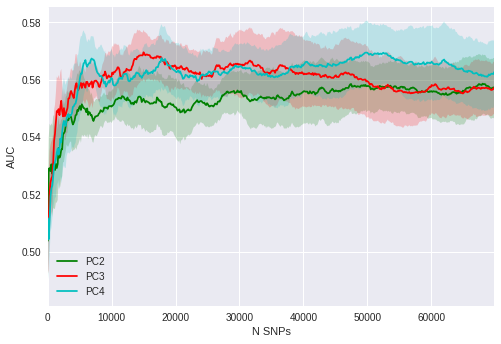

In [121]:
snp_data, pheno = util.load_data("/home/vcabeli/Documents/data/BP_final/BP.B37-final")
n_iter = 10
threshs = range(10, 70000, 140)
thresh_LD = 5
nb_pc_tot=5
time = range(10,70000,140)
time_pc = range(nb_pc_tot-2)
col='bgrcmk'

############
for PC in range(2,nb_pc_tot):
    print "========================= {} PCs =========================".format(PC)
    res_pval=iterate(snp_data, pheno,n_iter,threshs,thresh_LD,PC)


    for i in range(len(time)):
        res_pval[res_pval[:,i] == 0,i] = np.nan
        res_pval[np.isnan(res_pval[:,i]),i] = np.nanmedian(res_pval[:,i])
    sns.tsplot(np.power(res_pval,1),color=col[PC-1],ci=[0,95],time=time, condition="PC{}".format(PC))

sns.plt.ylabel('AUC')
sns.plt.xlabel('N SNPs')
sns.plt.savefig("fct_pc.pdf", format="pdf")

print "Wrote {}.".format("fct_pc.pdf")
plt.show()
